In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
sys.path.append('../src/')
import data_utils as du
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colormaps
from matplotlib.patches import Rectangle
import scipy.optimize as opt



In [ ]:


# Then collect from all patches the alpha and dyn data
patches = 20
hypotheses = []
features = []
for p in range(patches):
    # (data_sent, data_alpha, data_dyn, data_worldclim, data_dsm) = du.load_all_modalities_from_name(name=f'pecl-fig-{p}', path_folder='../content/sample_data', verbose=1)
    (data_sent, data_alpha, data_dyn, data_worldclim, data_dsm) = du.load_all_modalities_from_name(name=f'pecl176-{p}', 
                                                                        path_folder='/Users/tplas/data/2025-10 neureo/pecl-100-subsample-30km', verbose=0)
    if data_sent is None:
        continue
    # Land coverage serves as hypotheses
    # hypotheses.append(data_dyn.data)
    hypotheses.append(np.concatenate([data_dyn.data, data_dsm.data], axis=0))

    # This can definitely be cleaner but I use nan for undefined values
    f_dat = data_alpha.data
    f_dat[~np.isfinite(f_dat)] = np.nan

    ## set middle values to 0
    perc_threshold = 5 
    low_perc = np.percentile(f_dat, perc_threshold)
    high_perc = np.percentile(f_dat, 100-perc_threshold)
    f_dat = np.where((f_dat > low_perc) & (f_dat < high_perc), 0, f_dat)

    features.append(f_dat)    

# Z-score across patches for each feature and each hypothesis
feat_m = np.stack([np.nanmean(f) for f in np.stack(features, axis=-1)])
feat_std = np.stack([np.nanstd(f) for f in np.stack(features, axis=-1)]) + 1e-6
features = [(f - feat_m[:,None,None])/feat_std[:,None,None] for f in features]
hyp_m = np.stack([np.nanmean(h) for h in np.stack(hypotheses, axis=-1)])
hyp_std = np.stack([np.nanstd(h) for h in np.stack(hypotheses, axis=-1)])
hypotheses = [(h - hyp_m[:,None,None])/hyp_std[:,None,None] for h in hypotheses]

# Get names of hypotheses: different coarse land coverage classes
names = [k for k in du.create_cmap_dynamic_world().keys()]
names.append('dsm')

# Extract relevant dimensions
radius = 5 # pixels, excluding center pixel (so diameter = 2 * radius + 1)
N_features = features[0].shape[0]
N_pixels = features[0].shape[1]
N_hypotheses = hypotheses[0].shape[0]


In [5]:
features[0].max()

np.float64(15.903297142328784)

In [6]:

# Run through all patches, collecting spike triggered averages for each feature for each hypothesis
patch_stas = []
for p, (hypothesis, feature) in enumerate(zip(hypotheses, features)):
    print(f'Analysing patch {p+1} / {len(hypotheses)}')
    
    # Create empty region of interest maps: area around each pixel for each band
    rois = np.full([N_hypotheses, N_pixels - 2 * radius, N_pixels - 2 * radius,
                    radius * 2 + 1, radius * 2 + 1], np.nan)
    
    # Collect searchlight data for each pixel from all bands of current modality
    for h, hyp in enumerate(hypothesis):
        # print(f'Copying hyp {h} / {len(hypotheses)}')
        for row in range(radius, N_pixels - radius):
            for col in range(radius, N_pixels - radius):
                # Grab the relevant pixels from the band
                rois[h, row - radius, col - radius, :, :] = \
                    hyp[(row - radius):(row + radius + 1), (col - radius):(col + radius + 1)]
                    
    # Collect spike time averages for each band
    stas = []
    for h, hyp_rois in enumerate(rois):
        # print(f'Calculating spike triggered averages for hyp {h} / {len(rois)}')
        # Then create the spike time average: multiply each roi by the pixel value of the feature pixel
        hyp_stas = [hyp_rois * d[radius:(N_pixels-radius),radius:(N_pixels-radius),None,None] for d in feature]
        # Then average across all pixels and stack to get big output array
        hyp_stas = np.stack([np.nansum(sta.reshape([-1, radius*2+1, radius*2+1]), axis=0) for sta in hyp_stas])
        # And append to output stas
        stas.append(hyp_stas)
    patch_stas.append(np.stack(stas))
    
# Average across patches to get final stas
all_stas = np.nanmean(np.stack(patch_stas), axis=0)


Analysing patch 1 / 12
Analysing patch 2 / 12
Analysing patch 3 / 12
Analysing patch 4 / 12
Analysing patch 5 / 12
Analysing patch 6 / 12
Analysing patch 7 / 12
Analysing patch 8 / 12
Analysing patch 9 / 12
Analysing patch 10 / 12
Analysing patch 11 / 12
Analysing patch 12 / 12


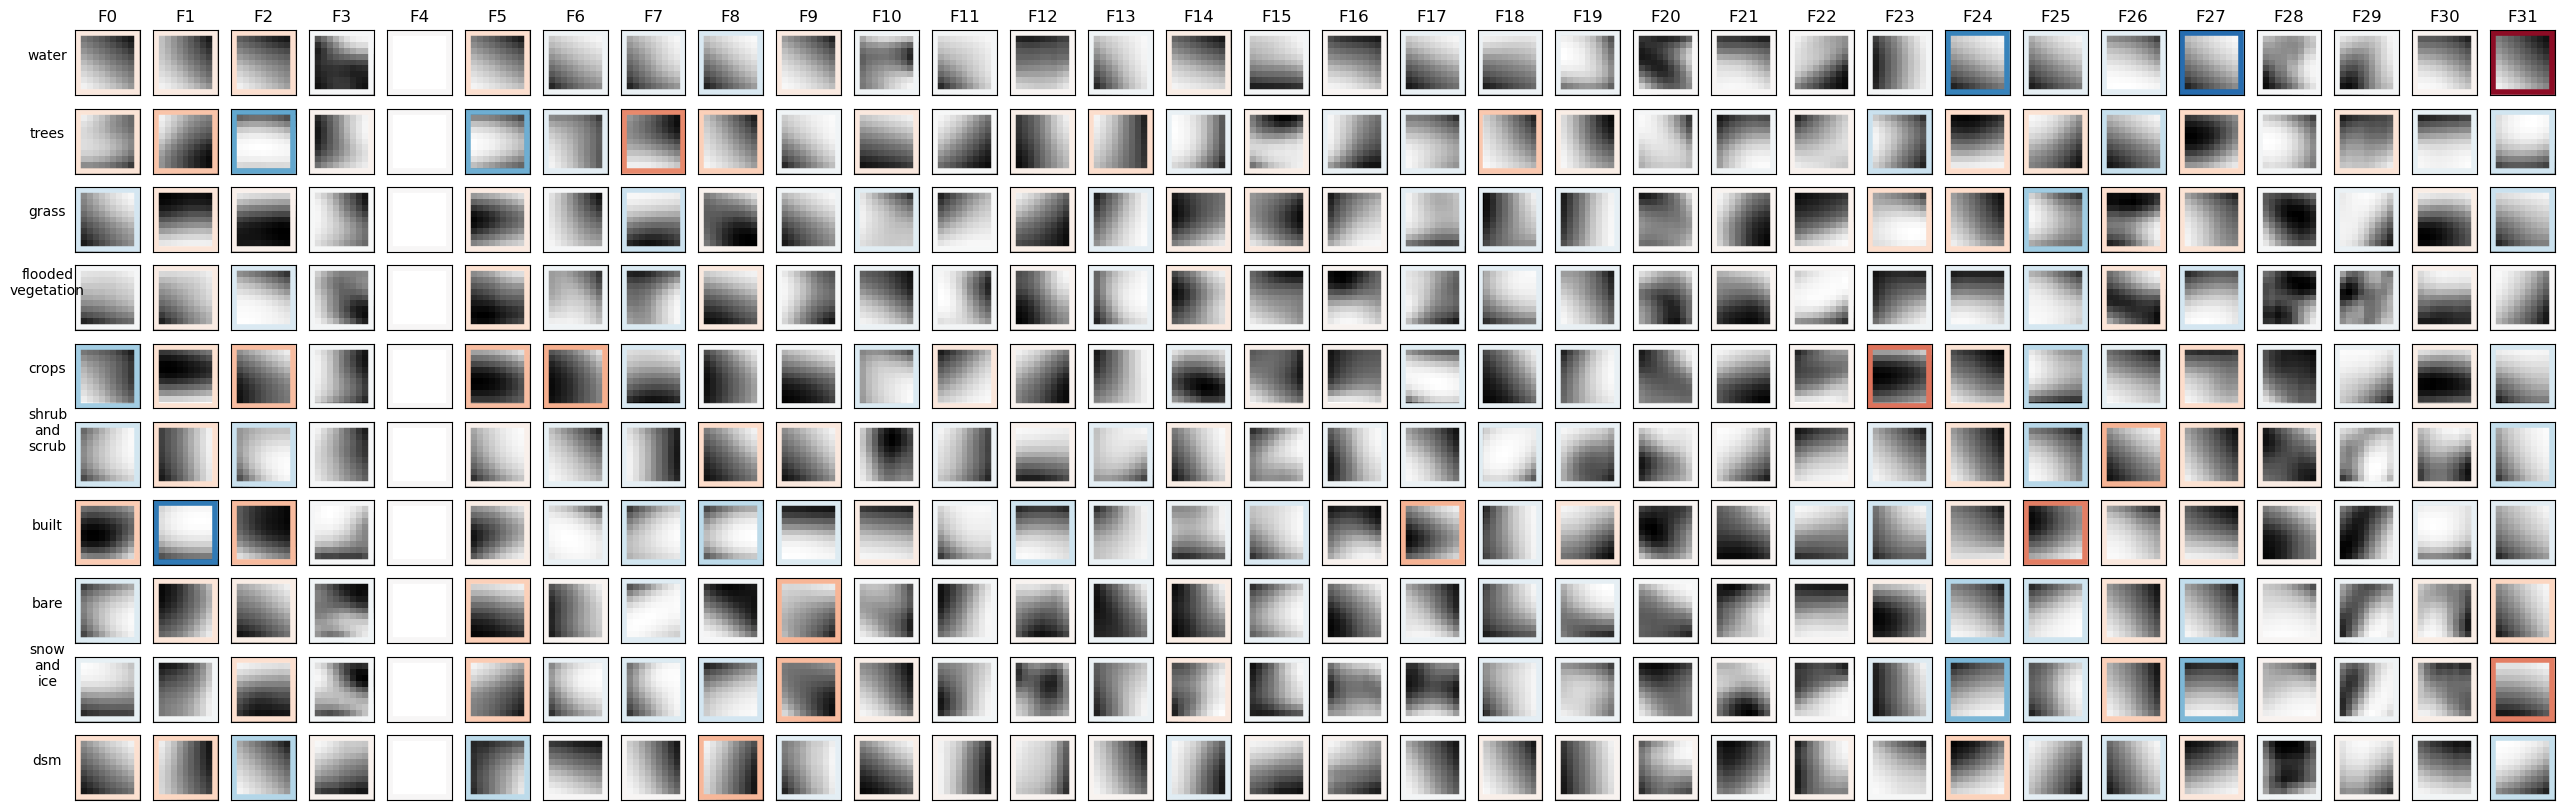

In [10]:

# Plot a selection
h_to_plot = len(all_stas)
f_to_plot = 32
plt.figure(figsize=(f_to_plot, h_to_plot))
# Color plot borders by average value
lim = np.nanmax(np.abs(all_stas[:h_to_plot, :f_to_plot]))
cm = colormaps.get_cmap('RdBu_r')
# Plot one tuning curve per hypothesis per feature
for row, hyp_stas in enumerate(all_stas[:h_to_plot]):
    for col, sta in enumerate(hyp_stas[:f_to_plot]):
        ax = plt.subplot(h_to_plot, f_to_plot, row * f_to_plot + col + 1)
        ax.imshow(sta,cmap='Greys')
        ax.add_patch(Rectangle([0, 0,], sta.shape[1]-1, sta.shape[0]-1,
            facecolor=[0,0,0,0], 
            edgecolor=cm((np.nanmean(sta)+lim)/(2*lim)),
            linewidth=4))
        ax.set_xticks([])
        ax.set_yticks([])
        if col == 0:
            ax.set_ylabel(names[row].replace('_','\n'), rotation=0, labelpad=20)
        if row == 0:
            ax.set_title(f'F{col}')
            

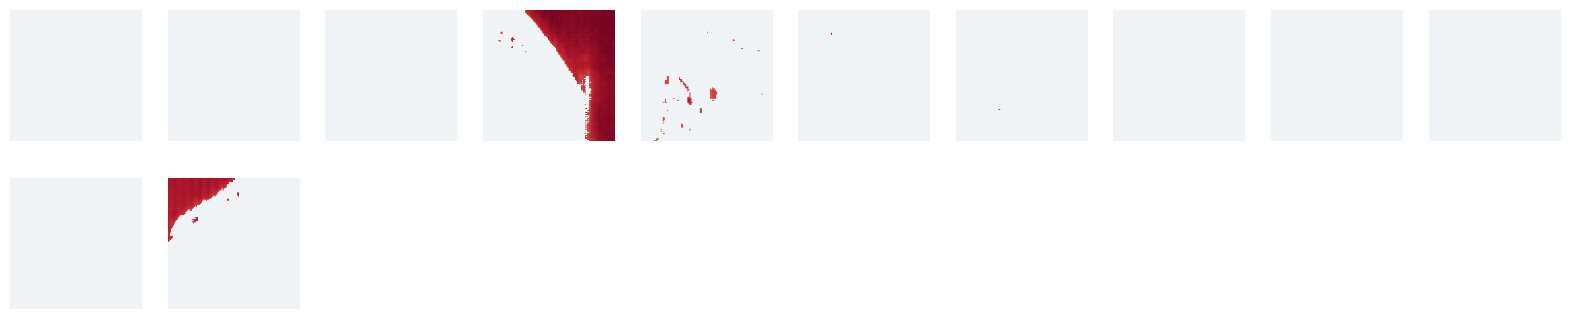

In [12]:
# Plot the map for a particular feature that you might like across patches
curr_f = 31

cols=10
rows=int(np.ceil(patches/cols))
lim = np.nanmax(np.abs(np.stack(features, axis=-1)[curr_f]))
plt.figure(figsize=(2*cols, 2*rows))
for p, feature in enumerate(features):
    plt.subplot(rows, cols, p + 1)
    plt.imshow(feature[curr_f], vmin=-lim, vmax=lim, cmap="RdBu_r")
    plt.axis('off')
    